# Benchmark: Evaluating the difficulty of tasks

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Visualisation of logs

In [3]:
with open("./main_results.json") as f:
    data = json.load(f)

data.keys()

dict_keys(['balance_simple', 'balance_hard', 'basketball', 'bookshelf_simple', 'bookshelf_hard', 'cabinet', 'crawl', 'cube', 'door', 'highbar', 'hurdle', 'insert_small', 'insert_normal', 'kitchen', 'maze', 'package', 'pole', 'powerlift', 'push', 'reach', 'room', 'run', 'sit_simple', 'sit_hard', 'slide', 'spoon', 'stair', 'stand', 'truck', 'walk', 'window'])

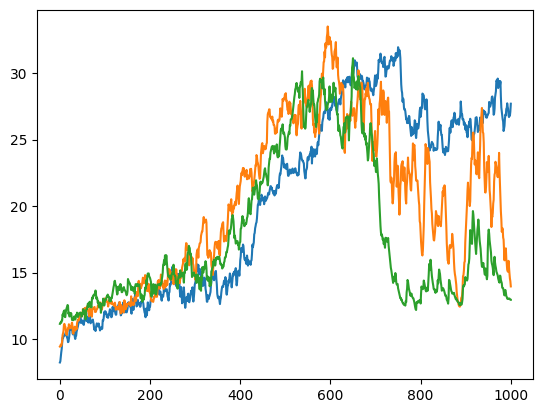

In [4]:

plt.plot(data["balance_simple"]["DreamerV3"]["seed_0"]["return"])
plt.plot(data["balance_simple"]["DreamerV3"]["seed_2"]["return"])
plt.plot(data["balance_simple"]["DreamerV3"]["seed_1"]["return"])

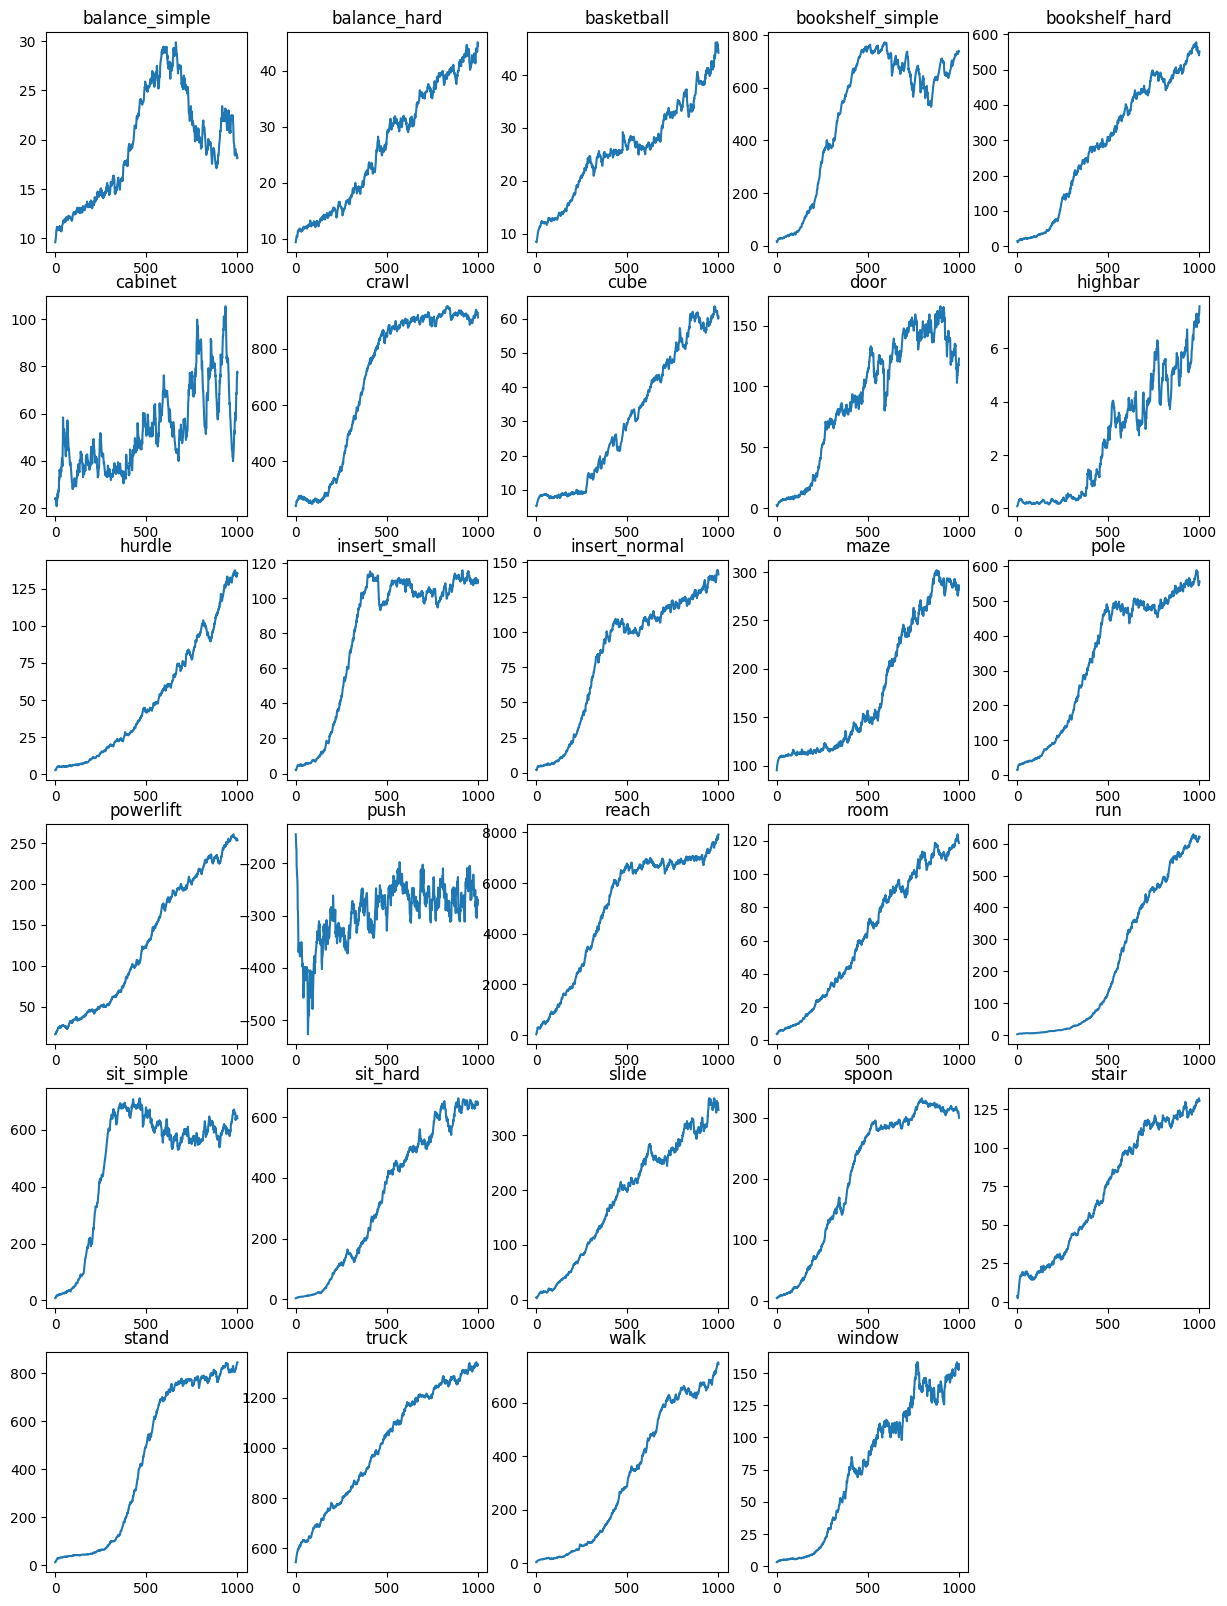

In [5]:
keys = list(data.keys())
keys.remove("package")
keys.remove("kitchen")

plt.figure(figsize=(15,20))
for i, key in enumerate(keys):
    seed0 = data[key]["DreamerV3"]["seed_0"]["return"]
    seed1 = data[key]["DreamerV3"]["seed_1"]["return"]
    seed2 = data[key]["DreamerV3"]["seed_2"]["return"]

    total = np.vstack((seed0, seed1, seed2))
    mean = np.mean(total, axis = 0)

    plt.subplot(6,5,i+1)
    plt.title(key)
    plt.plot(mean)
    

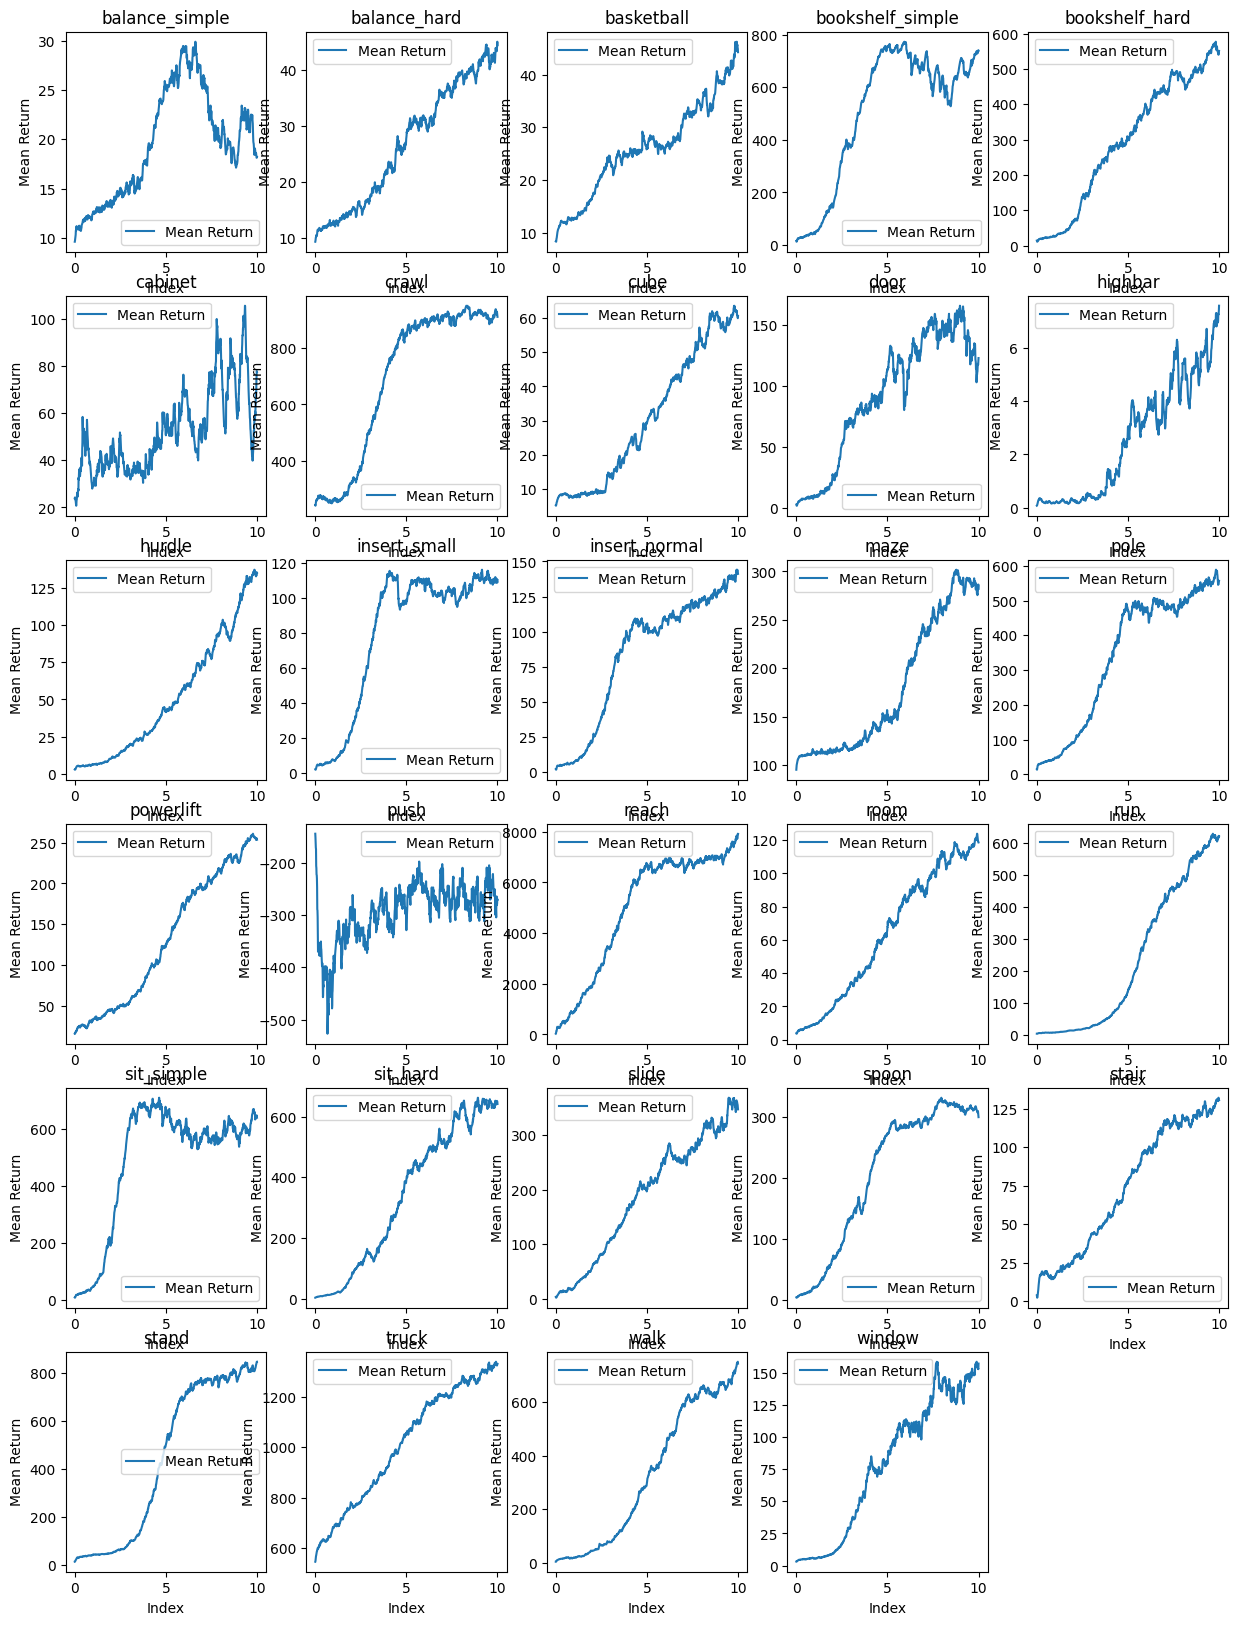

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'data' is defined as per the provided structure.
# Example: data = {"balance_simple": {"DreamerV3": {...}}, "package": {...}, "kitchen": {...}, ... }

# Extract the keys of interest from 'data'. 
# Remove keys that are not needed ('package', 'kitchen').
keys = list(data.keys())
if "package" in keys:
    keys.remove("package")
if "kitchen" in keys:
    keys.remove("kitchen")

# Set up the figure
plt.figure(figsize=(15, 20))

# Loop through each key in 'data' (excluding the removed ones)
for i, key in enumerate(keys):
    # Extract the return arrays for each seed
    seed0 = data[key]["DreamerV3"]["seed_0"]["return"]
    seed1 = data[key]["DreamerV3"]["seed_1"]["return"]
    seed2 = data[key]["DreamerV3"]["seed_2"]["return"]

    # Stack all seeds vertically to create a 2D array of shape (3, num_steps)
    returns_all_seeds = np.vstack((seed0, seed1, seed2))
    
    # Compute the mean across seeds (axis=0 averages along the seed dimension)
    mean_returns = np.mean(returns_all_seeds, axis=0)

    # Create a subplot for each environment/key
    plt.subplot(6, 5, i + 1)
    plt.title(key)
    # plt.plot(mean_returns, label='Mean Return')
    steps = data[key]["DreamerV3"]["seed_0"]["million_steps"]
    plt.plot(steps, mean_returns, label='Mean Return')

    plt.xlabel("Index")    # If you have step values, you can replace this with "Steps"
    plt.ylabel("Mean Return")
    plt.legend()

plt.tight_layout()
plt.show()


## Reward normalisation

In [6]:
def normalisation(signal):
    min_signal = np.min(signal)
    max_signal = np.max(signal)
    return (signal - min_signal)/(max_signal - min_signal)

As the rewards are different for each task, there is a need to normalise the rewards so that they can be compared with each other.

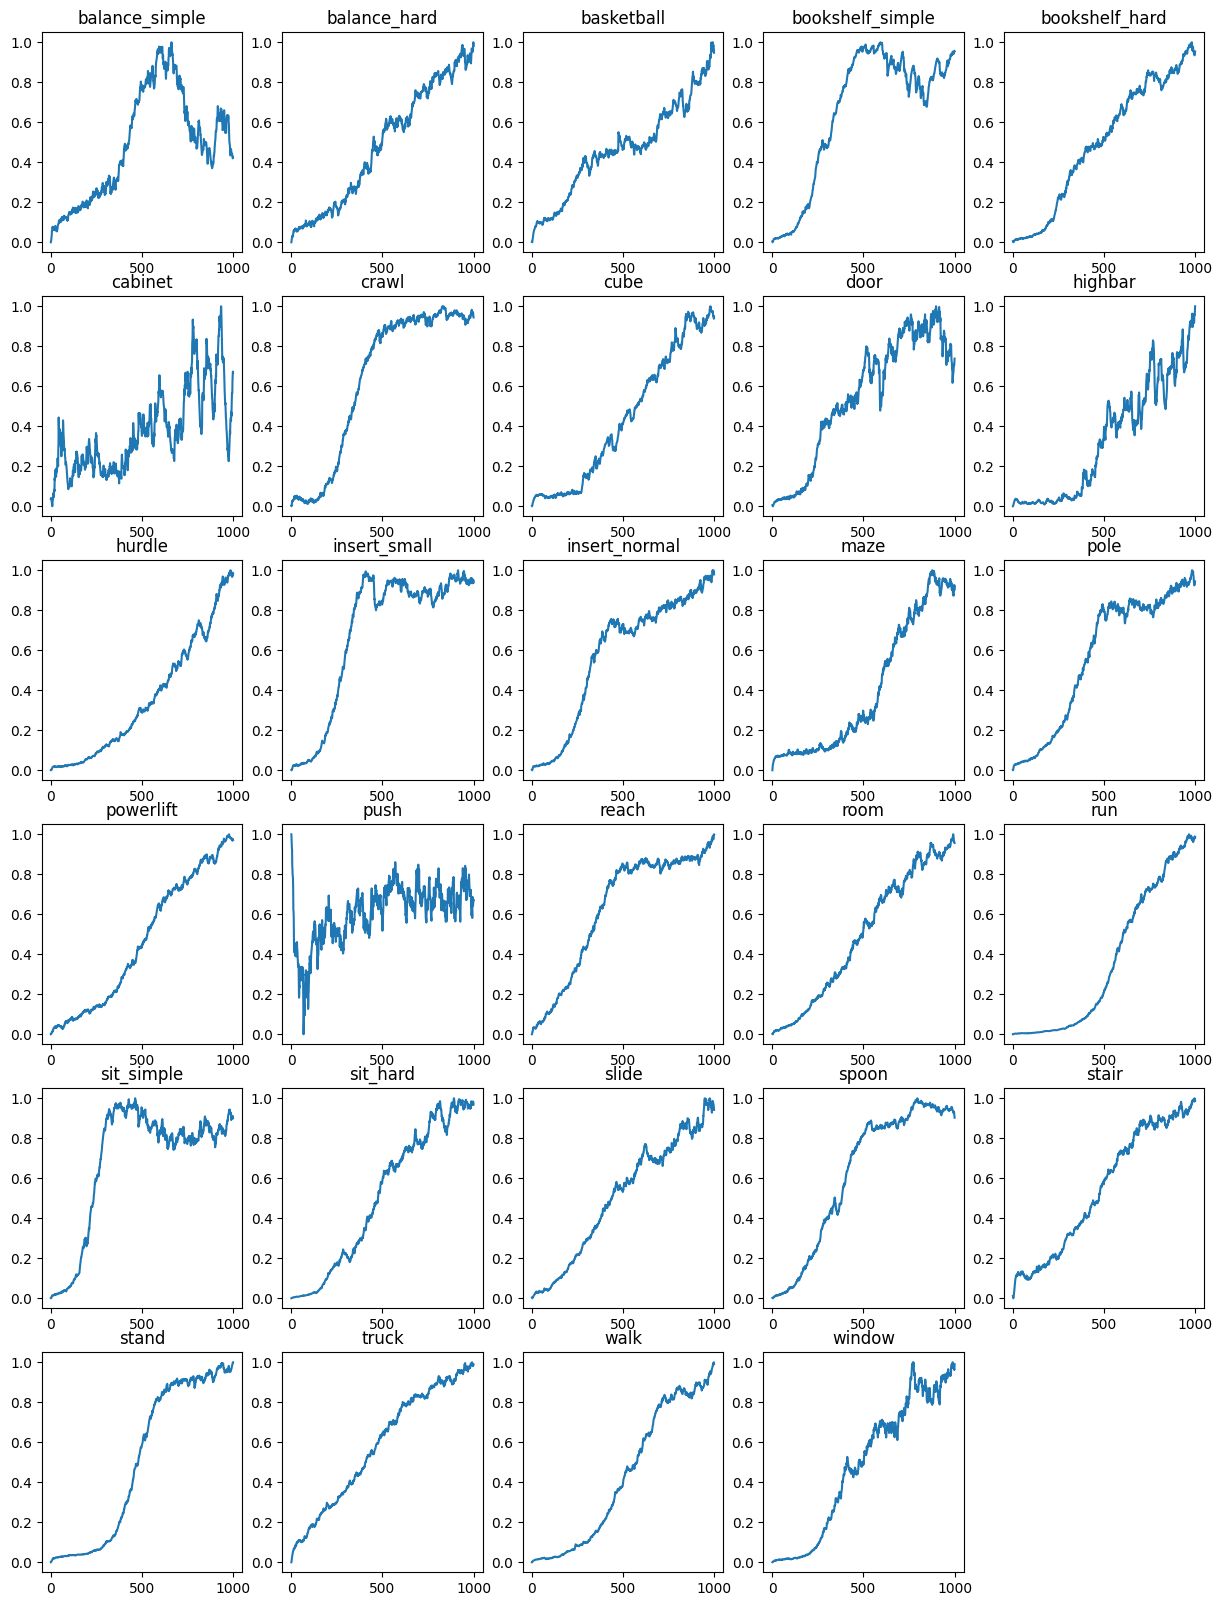

In [7]:
data_normalized = {}

plt.figure(figsize=(15,20))
for i, key in enumerate(keys):
    seed0 = data[key]["DreamerV3"]["seed_0"]["return"]
    seed1 = data[key]["DreamerV3"]["seed_1"]["return"]
    seed2 = data[key]["DreamerV3"]["seed_2"]["return"]

    total = np.vstack((seed0, seed1, seed2))
    mean = np.mean(total, axis = 0)

    data_normalized[key] = normalisation(mean)
    plt.subplot(6,5,i+1)
    plt.title(key)
    plt.plot(data_normalized[key])

## Complexity measure 1 : Area under the curve

In [8]:
def complexity_auc(signal):
    return 1-np.trapz(signal, np.arange(len(signal)))/len(signal)

A large area under the curve indicates that the curve is often close to its maximum value. Indeed, this metric measures the cumulative reward over time. A model that manages to approach its maximum reward quickly will therefore maximise this area.

In [9]:
complexity = {}

for i, key in enumerate(keys):
    
    complexity[key] = complexity_auc(data_normalized[key])


complexity_sorted = dict(sorted(complexity.items(), key=lambda item:item[1]))

## Complexity measure 2 : Gradient weighted average

In [10]:
def complexity_gradient(signal):
    val = np.sum(np.gradient(signal)* np.flip(np.arange(len(signal)) + 1)) / np.sum(np.arange(len(signal)) + 1) * len(signal)
    return np.inf if val <= 0 else 1/val

This metric considers that the simplest tasks to learn are those that allow the reward to evolve rapidly. The faster the reward evolves during the first iteration, the higher the metric. Conversely, the later the evolution, the less it is rewarded by the metric.

In [11]:
complexity2 = {}

for i, key in enumerate(keys):
    
    complexity2[key] = complexity_gradient(data_normalized[key])


complexity_sorted2 = dict(sorted(complexity2.items(), key=lambda item:item[1]))

## Complexity measure 3 : Convergence rate

In [12]:
def complexity_index_percentage(signal, threshold, min_index):
    max_threshold = threshold * np.max(signal)
    index = np.min(np.nonzero(signal >= max_threshold))
    index_corrected = index if index >= min_index else len(signal)
    return index_corrected/len(signal)

The principle behind this metric is similar to the previous one. The aim is to reward a task that can be learned quickly. To do this, we look at the minimum index that allows us to reach the maximum reward at threshold%. We then study the index/signal size ratio, which increases as the index increases.

In [13]:
complexity3 = {}

for i, key in enumerate(keys):
    
    complexity3[key] = complexity_index_percentage(data_normalized[key],0.8,50)


complexity_sorted3 = dict(sorted(complexity3.items(), key=lambda item:item[1]))

## Summary

In [14]:
order1 = sorted(complexity_sorted, key=complexity_sorted.get)
order2 = sorted(complexity_sorted2, key=complexity_sorted2.get)
order3 = sorted(complexity_sorted3, key=complexity_sorted3.get)


rank1 = {key: order1.index(key)+1 for key in complexity_sorted}
rank2 = {key: order2.index(key)+1 for key in complexity_sorted2}
rank3 = {key: order3.index(key)+1 for key in complexity_sorted3}

final_order = {key:rank1[key] + rank2[key] + rank3[key] for key in complexity_sorted}
final_order = sorted(final_order, key=final_order.get)

final_rank = {key: final_order.index(key)+1 for key in complexity_sorted}
final_rank_sorted = dict(sorted(final_rank.items(), key=lambda item:item[1]))

In [15]:
table = PrettyTable()
table.field_names = ["Task", "AUC Complexity rank", "Grad Complexity rank", "Index Complexity rank","Final rank"]

keys = list(final_rank_sorted.keys())
for key in keys:
    table.add_row([key, rank1[key], rank2[key], rank3[key], final_rank[key]])

print(table)

+------------------+---------------------+----------------------+-----------------------+------------+
|       Task       | AUC Complexity rank | Grad Complexity rank | Index Complexity rank | Final rank |
+------------------+---------------------+----------------------+-----------------------+------------+
|    sit_simple    |          1          |          1           |           1           |     1      |
|   insert_small   |          2          |          2           |           2           |     2      |
| bookshelf_simple |          3          |          3           |           3           |     3      |
|      crawl       |          4          |          4           |           4           |     4      |
|      reach       |          5          |          5           |           5           |     5      |
|      spoon       |          6          |          6           |           7           |     6      |
|      truck       |          8          |          7           |        